In [110]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import librosa
import sys
print(sys.executable)
import torch
print("Torch:", torch.__version__)
import whisper
print("Whisper loaded successfully")

c:\Users\ishir\OneDrive\Desktop\Hackathons\AccessAIthon2026\venv\Scripts\python.exe
Torch: 2.10.0+cpu
Whisper loaded successfully


In [111]:
model = whisper.load_model("base")
result = model.transcribe("test_audio.wav")
print(result["text"])

c:\Users\ishir\OneDrive\Desktop\Hackathons\AccessAIthon2026\venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 This is a waste protest.


### Using FFT (Fast Fourier Transform) to get rid of background noise.

Use :
$$\hat{Y}[f]=\sum_{n=0}^{N-1}y[n]\cdot e^{-(2\pi/N) jkn}$$

To do :
$$sp = \hat{Y}[f] = \sum_{t=0}^{T-1}\text{Amp}[t]\cdot e^{-(2\pi/T) jkt}$$


Which gives the $\text{Amp}$/$f$ arrays for the waveform "test_audio.wav". Performing $||\text{Amp}||^2$ gives $\text{PSD}$ (Power Spectral Density). Both of which $\text{Amp}(f)$ & $PSD(f)$ are plotted on the graph below. From the graph, it's sensible to come to the conclusion that the main speach audio starts after $2\text{kHz}$ and anything below that is random noise (i.e. as shown by the $\text{PSD}$ signal at $-8\text{kHz}$).

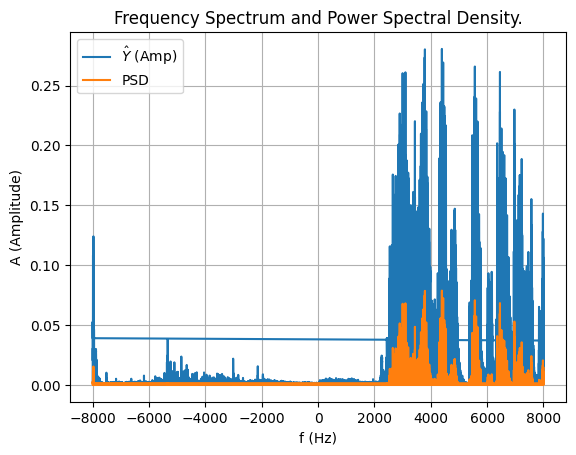

In [113]:
amp_original, sr_original = sf.read("test_audio.wav")
# if len(amp_original.shape) > 1:
#     amp_original = np.mean(amp_original, axis=1)
sr = 16000
amp = librosa.resample(amp_original, orig_sr=sr_original, target_sr=sr)
# total samples
N = len(amp)
# timestamps
# old thinking : t = np.arange(N/sr, step=1/sr)
t = np.arange(N) / sr
# Amplitude (A) after FFT
sp = np.fft.fft(amp)
# Magnitude of the amplitude (|A|) after FFT
abs_sp = np.abs(sp)
# Power Spectral Density (PSD) the square of the magnitude (|A|²) of the amplitude
PSD = np.abs(sp)**2
# Frequency bins corresponding to the FFT output
freq = np.fft.fftfreq(N, d=1/sr)
# Graphing the frequency spectrum and PSD
plt.plot(freq, abs_sp, label=r"$\hat{Y}$ (Amp)") # i took away the imaginary parts freq, sp.imag
plt.plot(freq, PSD, label="PSD")
plt.xlabel("f (Hz)")
plt.ylabel("A (Amplitude)")
plt.title("Frequency Spectrum and Power Spectral Density.")
plt.grid(True)
plt.legend()
plt.show()

### Inverse Real Fast Fourier Transform (IFFT)
Inverse Fast Fourier Transform for a complex-valued input (obtained previously from an FFT).
The purpose of the IFFT now will be to convert the signal from the $f$ domain back to the $t$ domain after slicing out
the specific part of the signal that we want to use (filtering out the part of the signal from $-8000\leq f (\text{Hz})< 300$ and keeping the signal from $f (\text{Hz})\geq 300$.

$$\text{Amp[t]} = \frac{1}{N}\cdot\sum_{k=0}^{N-1}\hat{Y}[k]\cdot e^{(2\pi/N) jkt}$$

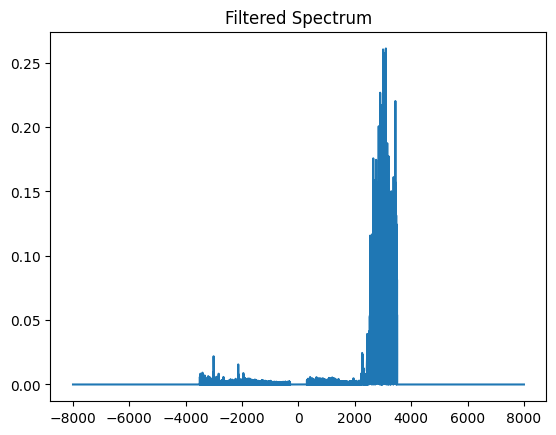

In [115]:
sp.shape
sp = sp.flatten()
sp_filtered = sp.copy()
mask = (np.abs(freq) >= 300) & (np.abs(freq) <= 3500)
sp_filtered = sp * mask

from numpy.fft import fftshift
plt.plot(fftshift(freq), fftshift(np.abs(sp_filtered)))
plt.title("Filtered Spectrum")
plt.show()

# Inverse FFT
filtered_time = np.real(np.fft.ifft(sp_filtered))

# Normalize
filtered_time /= np.max(np.abs(filtered_time))

# Save
sf.write("filtered_whispr_test.wav", filtered_time, sr)